# Data

We will set up a Convolutional Neural Network with PyTorch and train it to distinguish 9 different types of fish. The images are taken from the https://www.kaggle.com/crowww/a-large-scale-fish-dataset

# Imports

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [110]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define Transforms

Since the dataset contains already flipped and rotated images, we don't have to do that in the transform. Further, all images have size 590 x 445. To obtain equal height and width we crop the images. Moreover, we convert them to a tensor and normalize them with the recommended parameters (see https://pytorch.org/vision/stable/models.html).

In [111]:
transform = transforms.Compose([
    transforms.CenterCrop(445),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
    ])

# Load Data

In [112]:
data = datasets.ImageFolder("data", transform=transform)

In [113]:
train_size = int(0.8 * len(data))
test_size = len(data) - train_size

torch.manual_seed(23)

train_data, test_data = torch.utils.data.random_split(data, [train_size, test_size])

In [114]:
labels = data.classes
labels_map = {i: labels[i] for i in np.arange(len(labels))}
labels_map

{0: 'Black Sea Sprat',
 1: 'Gilt-Head Bream',
 2: 'Hourse Mackerel',
 3: 'Red Mullet',
 4: 'Red Sea Bream',
 5: 'Sea Bass',
 6: 'Shrimp',
 7: 'Striped Red Mullet',
 8: 'Trout'}

In [115]:
train_dataloader = DataLoader(train_data, batch_size=10, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=10, shuffle=True)

We plot one batch to verify the images got shuffled.

In [116]:
images, labels = next(iter(train_dataloader))

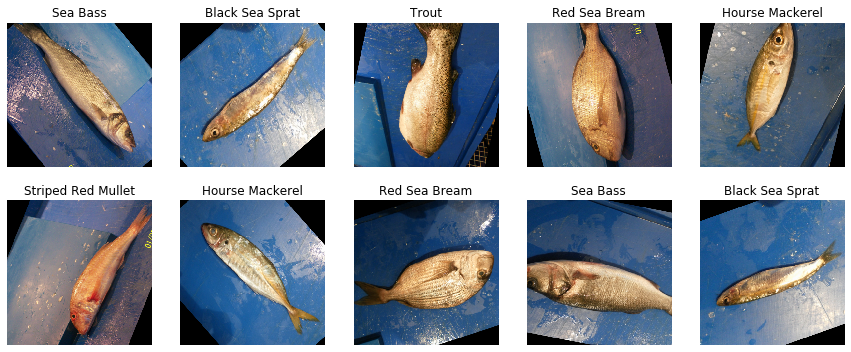

In [117]:
figure = plt.figure(figsize=(15,6))
cols, rows = 5, 2

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
    
for i in range(len(images)):
    img = images[i]
    label = int(labels[i])
    img_inv = inv_normalize(img)
    figure.add_subplot(rows, cols, i+1)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(np.transpose(img_inv.numpy(), (1,2,0)))
plt.show()

# Define Model

We will use a neural network with two convolutional layers, two pooling layers and three fully connected layers.

In [118]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(109*109*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 9)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 109*109*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [119]:
torch.manual_seed(32)
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=190096, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=9, bias=True)
)

# Train Model

In [120]:
import time

In [121]:
def train_loop(dataloader, model, criterion, optimizer):
    size = len(dataloader.dataset)
    for batch, (X_train, y_train) in enumerate(dataloader):
        
        y_pred = model(X_train)
        loss_test = criterion(y_pred, y_train)

        optimizer.zero_grad()
        loss_test.backward()
        optimizer.step()

        if batch % 100 == 0:
            print(f"batch: {batch:4} [{len(X_train)*batch:4}/{len(X_train)*len(dataloader):4}]  \
                  loss: {loss_test.item():10.8f}")

In [122]:
def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    test_correct = 0

    with torch.no_grad():
        for X_test, y_test in dataloader:
            y_pred = model(X_test)
            test_loss += criterion(y_pred, y_test).item()
            predicted = torch.max(y_pred.data, 1)[1]
            batch_correct = (predicted == y_test).sum()
            test_correct += batch_correct

    print(f"Test Error: \n Accuracy: {(100*test_correct/size):>0.1f}%, Avg loss: {test_loss/num_batches:>8f} \n")

In [123]:
epochs = 3
start_time = time.time()

for t in range(epochs):
    print(f"Epoch {t+1}\n-----------------------------------------")
    train_loop(train_dataloader, CNNmodel, criterion, optimizer)
    test_loop(test_dataloader, CNNmodel, criterion)
    current_time = time.time()
    print(f" Duration: {current_time - start_time:.0f} seconds")

Epoch 1
-----------------------------------------
batch:    0 [   0/7200]                    loss: 2.22433043
batch:  100 [1000/7200]                    loss: 0.69223899
batch:  200 [2000/7200]                    loss: 1.24263000
batch:  300 [3000/7200]                    loss: 0.39126882
batch:  400 [4000/7200]                    loss: 0.28438646
batch:  500 [5000/7200]                    loss: 0.34529573
batch:  600 [6000/7200]                    loss: 0.57186162
batch:  700 [7000/7200]                    loss: 0.29585308
Test Error: 
 Accuracy: 95.7%, Avg loss: 0.137234 

 Duration: 557 seconds
Epoch 2
-----------------------------------------
batch:    0 [   0/7200]                    loss: 0.03483895
batch:  100 [1000/7200]                    loss: 0.01914326
batch:  200 [2000/7200]                    loss: 0.02668038
batch:  300 [3000/7200]                    loss: 0.01859356
batch:  400 [4000/7200]                    loss: 0.00201006
batch:  500 [5000/7200]                    lo

In the first epoch the model reaches an accuracy of 95.7%. In the second and third epoch the accuracy is decreasing which indicates overfitting. Thus, one epoch would be enough for training the model.